<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

In [ ]:
if tmrw.hasTest:
  study()
else:
  if today.hasHomework:
    doHw()
  if today.freeTime < hours(1):
    rest()
  else:
    study()

Or something like that, I'm sure I could complexify it, but I like my relatively simple psudeo code because thats roughly how I function.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a way to predict the value of a distribution by comparing the input to some threshold and walking along a tree until you find a leaf and emitting that value. Equivilent to a bunch of step functions

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

Depth allows you to figure out how many layers deep the tree can get, how many questions it will ask. If you get to each leaf having very few nodes then its overfitting and if the error in each region is too high then you're underfitting.

**Task4:**

How are BART models similar and different from a decision tree?

BART is a decision tree++ in that its many smaller decision trees each trying to find some feature in the data and collectively casting a "vote" which gets combined into a prediction. The key part of BART is the tree picking and pruning to get meaningful effects from many trees rather than relearning the same feature 50 times.

**Task5**:

Why would we use a BART model instead of a decision tree?

Decision trees tend to learn very small patterns and overfit, BART takes that and trys to patch the problems so that the result is something with a strong predictive capability.

## Bartian Penguins

In [ ]:
!pip install pymc-bart
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [ ]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [ ]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [ ]:
X = penguins[['bill_length', 'bill_depth', 'flipper_length']]
Y = penguins['body_mass']

In [ ]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata = pm.sample(compute_convergence_checks=False)

Output()

In [ ]:
pm.sample_posterior_predictive(idata,model_penguin, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

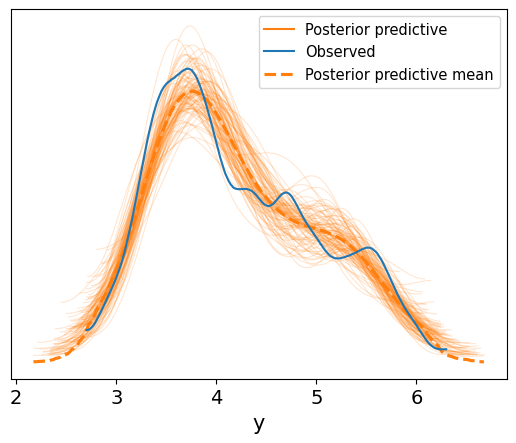

In [ ]:
ax = az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


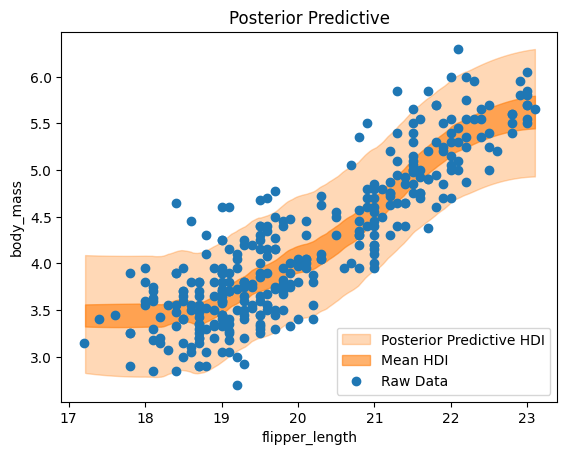

In [ ]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X)
fig, ax = plt.subplots()

az.plot_hdi(
    x=X['flipper_length'],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X['flipper_length'],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

It feels like its getting a very solid association between length and mass as it follows the bulk of the points very well. It does however struggle a little bit with the fact that the points have some noise to them but the HDI seems about right.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>], dtype=object)

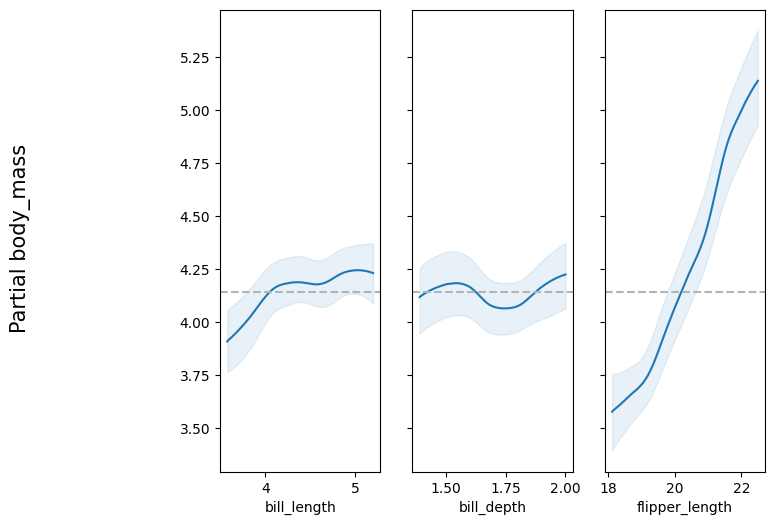

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>], dtype=object)

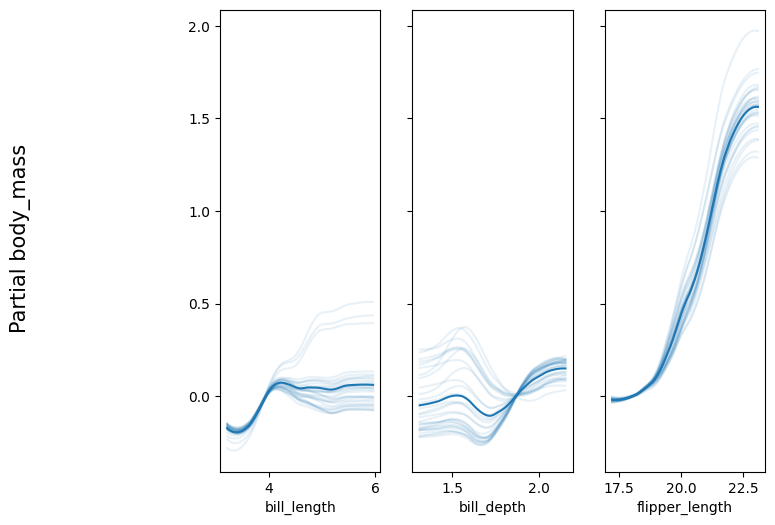

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

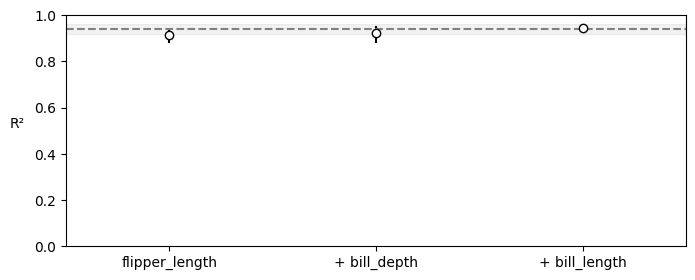

In [ ]:
vi = pmb.compute_variable_importance(idata, μ_, X)

pmb.plot_variable_importance(vi)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

What I immediately notice from the PDG is that the bill information looks to have nonlinear or minimal influence on the body mass which is counter intuivie, while the flipper length has a very clear linear relationship which is nice to see.

Next from the ICE plots its clear that theres some interaction between the items for Bill Length > 4 or depth < 1.8. Especially around Length 4-5 and Depth 1.6-1.8 where the segments are non linear resulting in divergent paths.
Flipper length remains independent

Finally the VI plot sugguests that everything is nesisary which we could see from the very strong interactions, so Flipper Length probably is indepdnet but important while thr other two have astrange unteraction that makes them both important together